In [9]:
%matplotlib inline
#from geostatsmodels import utilities, kriging, variograms, model, geoplot
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform, cdist
import statsmodels.formula.api as sm

In [10]:
from __init__ import *
from rain import *
from common import *

In [11]:
path = './input/'

rg = Rain(path=path, name='StLouis_MSD_gage_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rad = Rain(path=path, name='StLouis_MSD_radar_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rg.ll_file = 'StLouis_MSD_lat_lon_{YEAR}.csv'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()

In [12]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
%aimport common
%aimport rain

In [13]:
def get_fit(df, col, latlon=True, plot=False):
    df = df[['lon', 'lat', col]].dropna(how='any')
    df.columns = ['lon', 'lat', 'col']
    result = sm.ols(formula="col ~ lon + lat", data=df).fit()
    fit = result.params['Intercept'] + result.params['lon']*df.lon +result.params['lat']*df.lat
    if plot:
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
        for l, ax in zip(['lon', 'lat'], axes):
            ax.scatter(x=df[l], y=df.col)
            ax.scatter(df[l], fit, c='r')
            ax.set_ylabel('Rain Rate (mm/hr)')
            ax.set_xlabel(l)
            ax.set_title('Trend in ' + l)
    return fit

In [14]:
rg.get_rainiest(10, time_step='1H', base=0)
z = rg.rainiest[:]

z.X = z.X -z.X.min()
z.Y = z.Y -z.Y.min()

res = z[range(5)]
for col in z.columns[5:]:
    fit = get_fit(z, col)
    res = res.join(pd.DataFrame({col: z[col]-fit+z[col].mean()}))

In [331]:
from rpy2.robjects import pandas2ri, r, globalenv
from rpy2.robjects.packages import STAP
pandas2ri.activate()

with open('SVG.r', 'r') as f:
    string = f.read()
rfuncs = STAP(string, "rfuncs")

In [364]:
def func(res, i, plot_v=True, plot_k=True):
    r_res = res[[0,1,2,3,4, i]].dropna(how='any')

    v = pandas2ri.ri2py(rfuncs.get_variogram(r_res))
    v1 = pandas2ri.ri2py(rfuncs.get_iSVG(r_res, 6, target_np=300, max_bnd=25))
    if plot_v:
        v.plot(x='dist', y='gamma', marker = 'o', figsize=(8,4))
        v1.plot(x='dist', y='gamma', marker = 'o', figsize=(8,4))

    model = 'Sph'
    psill = r_res.var()[4]
    for j in range(len(v)):
        if v.gamma[j] > psill:
            rng = v.dist[j]
            break
    k = pandas2ri.ri2py(rfuncs.get_krige(r_res, psill, model, rng))
   
    if plot_k:
        fig, ax = plt.subplots()
        vmin = max(0, res[[i]].min().values[0])
        vmax = res[[i]].max().values[0]
        ax.scatter(k.x, k.y, c=k['var1.pred'], cmap='gist_earth_r', marker='s', edgecolors='none', s=5*100, vmin=vmin, vmax=vmax)
        scat = ax.scatter(res.X, res.Y, c=res[[i]], cmap='gist_earth_r', edgecolors='1', vmin=vmin, vmax=vmax)
        ax.set_xlim(0,70)
        ax.set_ylim(0,50)
        ax.set_title('Distance to sill: {dts}km'.format(dts=round(rng)))
        plt.colorbar(scat)
        plt.show()

[using ordinary kriging]


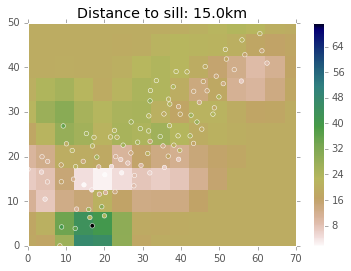

[using ordinary kriging]


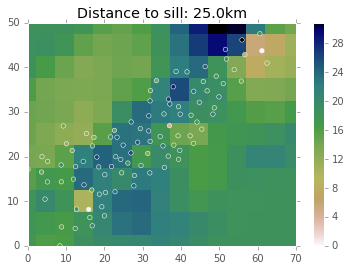

[using ordinary kriging]


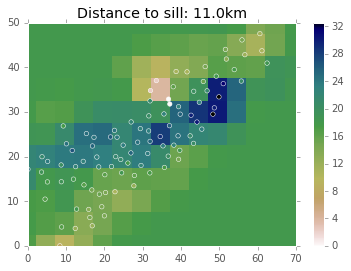

[using ordinary kriging]


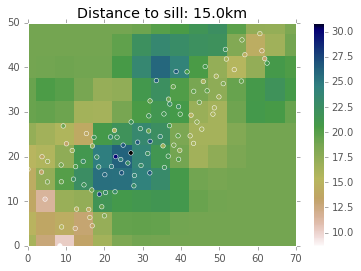

[using ordinary kriging]


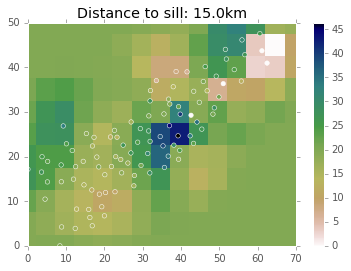

[using ordinary kriging]


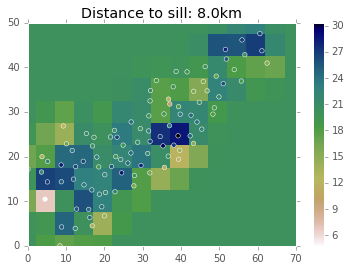

[using ordinary kriging]


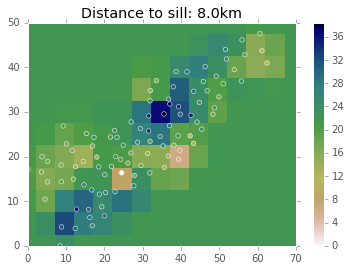

[using ordinary kriging]


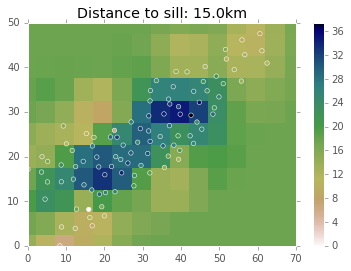

[using ordinary kriging]


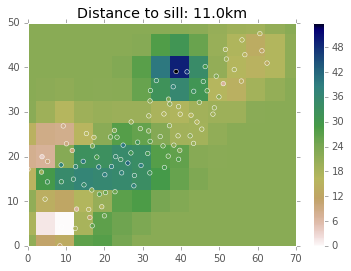

[using ordinary kriging]


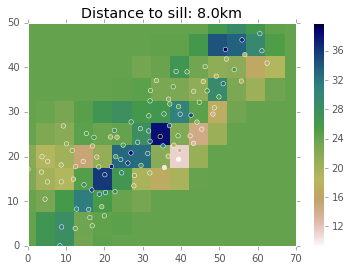

In [366]:
for i in range(5,15):
    func(res, i, plot_v=False)

In [280]:
r_vgm = r('vgm')
vgm_output = pandas2ri.ri2py(r_vgm(psill, model, rng))